<a href="https://colab.research.google.com/github/afifahnita/T2_WEB_SCRAPING/blob/main/Nita_Data_X_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning and Processing
This notebook performs cleaning and shortening of tweet data about bahlil and Raja Ampat mining activities.

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [ ]:
# Load the data
df = pd.read_csv('/content/acab (2).csv')

In [ ]:
# Initial data inspection
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset shape: (1509, 15)

First few rows:


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1970051475050013088,Mon Sep 22 10:05:43 +0000 2025,0,@boysdontcry2811 @Freshman2482647 ça veut pas ...,1970066976375451921,NaN,chevalbase,fr,NaN,0,0,0,https://x.com/undefined/status/197006697637545...,1402196042288963584,NaN
1,1970066804178649429,Mon Sep 22 10:05:02 +0000 2025,0,#ACAB hinding hindi sila magiging kakampi!,1970066804178649429,NaN,NaN,tl,NaN,0,0,0,https://x.com/undefined/status/197006680417864...,1164706738307604480,NaN
2,1970066790421274775,Mon Sep 22 10:04:59 +0000 2025,0,#ACAB,1970066790421274775,NaN,NaN,qht,NaN,0,0,0,https://x.com/undefined/status/197006679042127...,1609420851820244995,NaN
3,1970051475050013088,Mon Sep 22 10:04:01 +0000 2025,0,@boysdontcry2811 @Freshman2482647 quand tu tra...,1970066545385644188,NaN,boysdontcry2811,fr,NaN,0,1,0,https://x.com/undefined/status/197006654538564...,1402196042288963584,NaN
4,1969885599726473511,Mon Sep 22 10:03:52 +0000 2025,1,@JdponTransfem Donc acab mais pas tous les mil...,1970066510451556846,NaN,JdponTransfem,fr,NaN,0,0,0,https://x.com/undefined/status/197006651045155...,1832910981107724288,NaN


# Pembersihan Data

In [ ]:
# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [ ]:
# Clean text data
def clean_text(text):
    if pd.isna(text):
        return text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(text.split())
    text = text.replace('&amp;', 'dan')
    return text.lower()
df['cleaned_text'] = df['full_text'].apply(clean_text)

In [ ]:
# Extract hashtags
def extract_hashtags(text):
    if pd.isna(text):
        return []
    return re.findall(r'#(\w+)', text)
df['hashtags'] = df['full_text'].apply(extract_hashtags)

In [ ]:
# Handle missing values
df['in_reply_to_screen_name'].fillna('', inplace=True)
df['location'].fillna('', inplace=True)
df['image_url'].fillna('', inplace=True)

/tmp/ipython-input-3931258595.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['in_reply_to_screen_name'].fillna('', inplace=True)
/tmp/ipython-input-3931258595.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

# Data Shortening and Filtering

In [ ]:
# Filter for relevant columns
columns_to_keep = ['created_at', 'username', 'cleaned_text', 'hashtags',
                   'favorite_count', 'retweet_count', 'reply_count', 'quote_count',
                   'image_url', 'location', 'lang', 'tweet_url']
df_clean = df[columns_to_keep]

In [ ]:
# Remove duplicate tweets (based on cleaned text)
df_clean = df_clean.drop_duplicates(subset=['cleaned_text'])

In [ ]:
# Filter for tweets that mention key terms
keywords = ['acab']
def contains_keywords(text):
    if pd.isna(text):
        return False
    return any(keyword in text for keyword in keywords)
df_filtered = df_clean[df_clean['cleaned_text'].apply(contains_keywords)]

In [ ]:
# Sort by engagement (favorites + retweets)
df_filtered['engagement'] = df_filtered['favorite_count'] + df_filtered['retweet_count']
df_sorted = df_filtered.sort_values('engagement', ascending=False)

/tmp/ipython-input-3447588314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['engagement'] = df_filtered['favorite_count'] + df_filtered['retweet_count']


# Analisis Sentimen (Basic)

In [ ]:
import pandas as pd
from transformers import pipeline

# 1. Load model sentimen Bahasa Indonesia
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

# 2. Pastikan df_sorted dan kolom 'cleaned_text' ada
try:
    if 'df_sorted' in locals() and 'cleaned_text' in df_sorted.columns:
        # 3. Terapkan analisis sentimen otomatis
        def get_sentiment(text):
            if pd.isna(text) or text.strip() == "":
                return 'neutral'
            result = classifier(text[:512])[0]  # max token limit
            return result['label'].lower()  # 'positive', 'negative', 'neutral'

        df_sorted['sentiment'] = df_sorted['cleaned_text'].apply(get_sentiment)
        print(df_sorted[['cleaned_text', 'sentiment']])
    else:
        print("df_sorted dataframe or 'cleaned_text' column not found. Please ensure previous steps ran successfully.")

except Exception as e:
    print(f"Terjadi error saat menjalankan model sentimen: {e}")


Device set to use cpu


                                           cleaned_text sentiment
824                      activism is not terrorism acab  negative
729   this is a fucking child walang kamuwang muwang...   neutral
617   repeat after me acab acab acab ph media stop c...  negative
547   always remember that the cops were never on ou...  negative
369   akun asu bajingan these acab doesnt even learn...  negative
...                                                 ...       ...
1465                                     evergreen acab  positive
1459  preman berkostum budaya kultural disebut islam...  negative
1456                                 my opinion is acab   neutral
1452                       tuh kan buzzer itu dari acab  negative
3     quand tu travailles pour letat que tu le veuil...  positive

[997 rows x 2 columns]


# Menyimpan Data Clean

In [ ]:
# Save to new CSV
df_sorted.to_csv('cleaned_acab_tweets.csv', index=False)
print(f"Final cleaned dataset shape: {df_sorted.shape}")
print("\nSample of cleaned data:")
df_sorted.head()

Final cleaned dataset shape: (997, 14)

Sample of cleaned data:


,created_at,username,cleaned_text,hashtags,favorite_count,retweet_count,reply_count,quote_count,image_url,location,lang,tweet_url,engagement,sentiment
824,2025-09-21 13:10:11+00:00,NaN,activism is not terrorism acab,[ACAB],31761,12665,33,236,https://pbs.twimg.com/amplify_video_thumb/1969...,,en,https://x.com/undefined/status/196975100894030...,44426,negative
729,2025-09-21 13:58:33+00:00,NaN,this is a fucking child walang kamuwang muwang...,[ACAB],10651,3473,173,331,https://pbs.twimg.com/amplify_video_thumb/1969...,,tl,https://x.com/undefined/status/196976318085661...,14124,neutral
617,2025-09-21 15:18:48+00:00,NaN,repeat after me acab acab acab ph media stop c...,[],3416,1408,1,9,,,en,https://x.com/undefined/status/196978337716439...,4824,negative
547,2025-09-21 16:21:46+00:00,NaN,always remember that the cops were never on ou...,[ACAB],2393,905,0,12,,,en,https://x.com/undefined/status/196979922135749...,3298,negative
369,2025-09-22 00:23:18+00:00,NaN,akun asu bajingan these acab doesnt even learn...,[],2018,508,1,5,,,en,https://x.com/undefined/status/196992040461473...,2526,negative


#Hasil Analisis dan Visual

Positif: 389 (39.02%)
Netral : 369 (37.01%)
Negatif: 239 (23.97%)


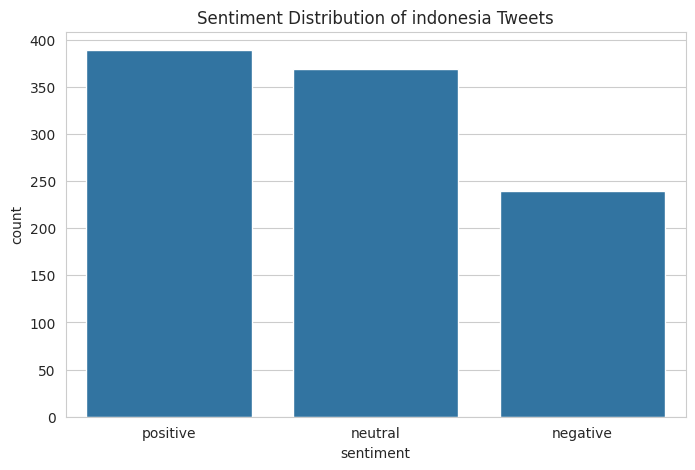

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sorted, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution of indonesia Tweets')

sentiment_counts = df_sorted['sentiment'].value_counts()
total = sentiment_counts.sum()

print(f"Positif: {sentiment_counts.get('positive', 0)} ({sentiment_counts.get('positive', 0)/total:.2%})")
print(f"Netral : {sentiment_counts.get('neutral', 0)} ({sentiment_counts.get('neutral', 0)/total:.2%})")
print(f"Negatif: {sentiment_counts.get('negative', 0)} ({sentiment_counts.get('negative', 0)/total:.2%})")

plt.show()

In [ ]:
print("\nContoh Data Positif:")
print(df_sorted [df_sorted['sentiment'] == 'positive'] ['cleaned_text'].head (1).values[0])

print("\nContoh Data Negatif:")
print(df_sorted [df_sorted['sentiment'] == 'negative'] ['cleaned_text'].head(1).values[0])

print("\nContoh Data Netral:")
print(df_sorted [df_sorted['sentiment'] == 'neutral'] ['cleaned_text'].head (1).values[0])


Contoh Data Positif:
and hello kitty says acab what are we doing guys

Contoh Data Negatif:
activism is not terrorism acab

Contoh Data Netral:
this is a fucking child walang kamuwang muwang mga walang hiya kayo acab


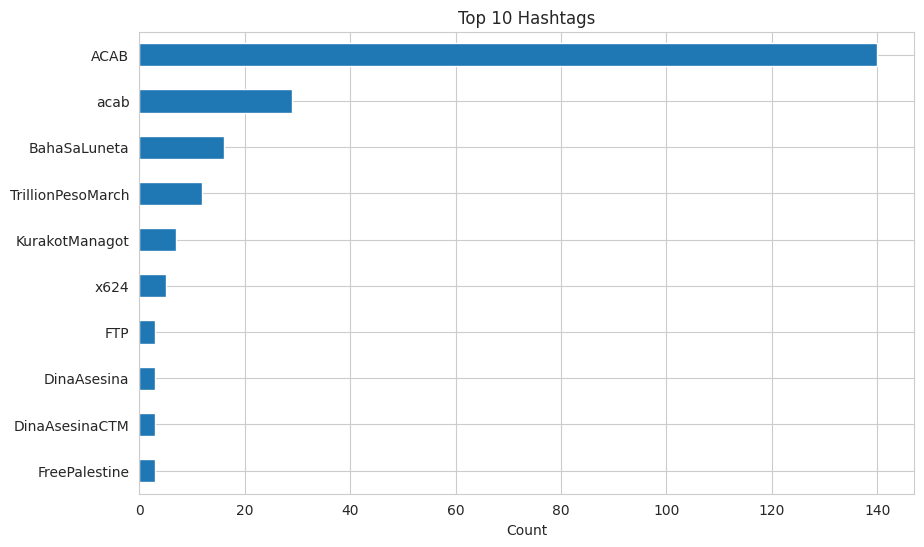

In [ ]:
# Top hashtags
all_hashtags = [tag for sublist in df_sorted['hashtags'] for tag in sublist]
hashtag_counts = pd.Series(all_hashtags).value_counts().head(10)

# Check if hashtag_counts is empty before plotting
if not hashtag_counts.empty:
    plt.figure(figsize=(10, 6))
    hashtag_counts.plot(kind='barh')
    plt.title('Top 10 Hashtags')
    plt.xlabel('Count')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("No hashtags found to display the top 10.")

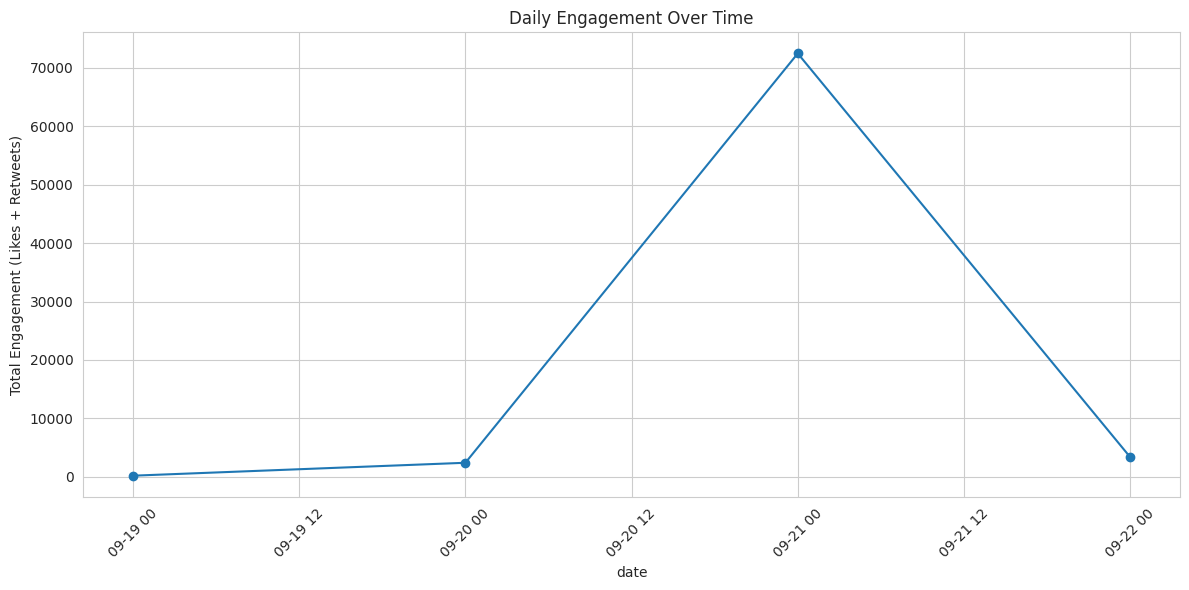

In [ ]:
# Engagement over time
df_sorted['date'] = df_sorted['created_at'].dt.date
daily_engagement = df_sorted.groupby('date')['engagement'].sum()
plt.figure(figsize=(12, 6))
daily_engagement.plot(marker='o')
plt.title('Daily Engagement Over Time')
plt.ylabel('Total Engagement (Likes + Retweets)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


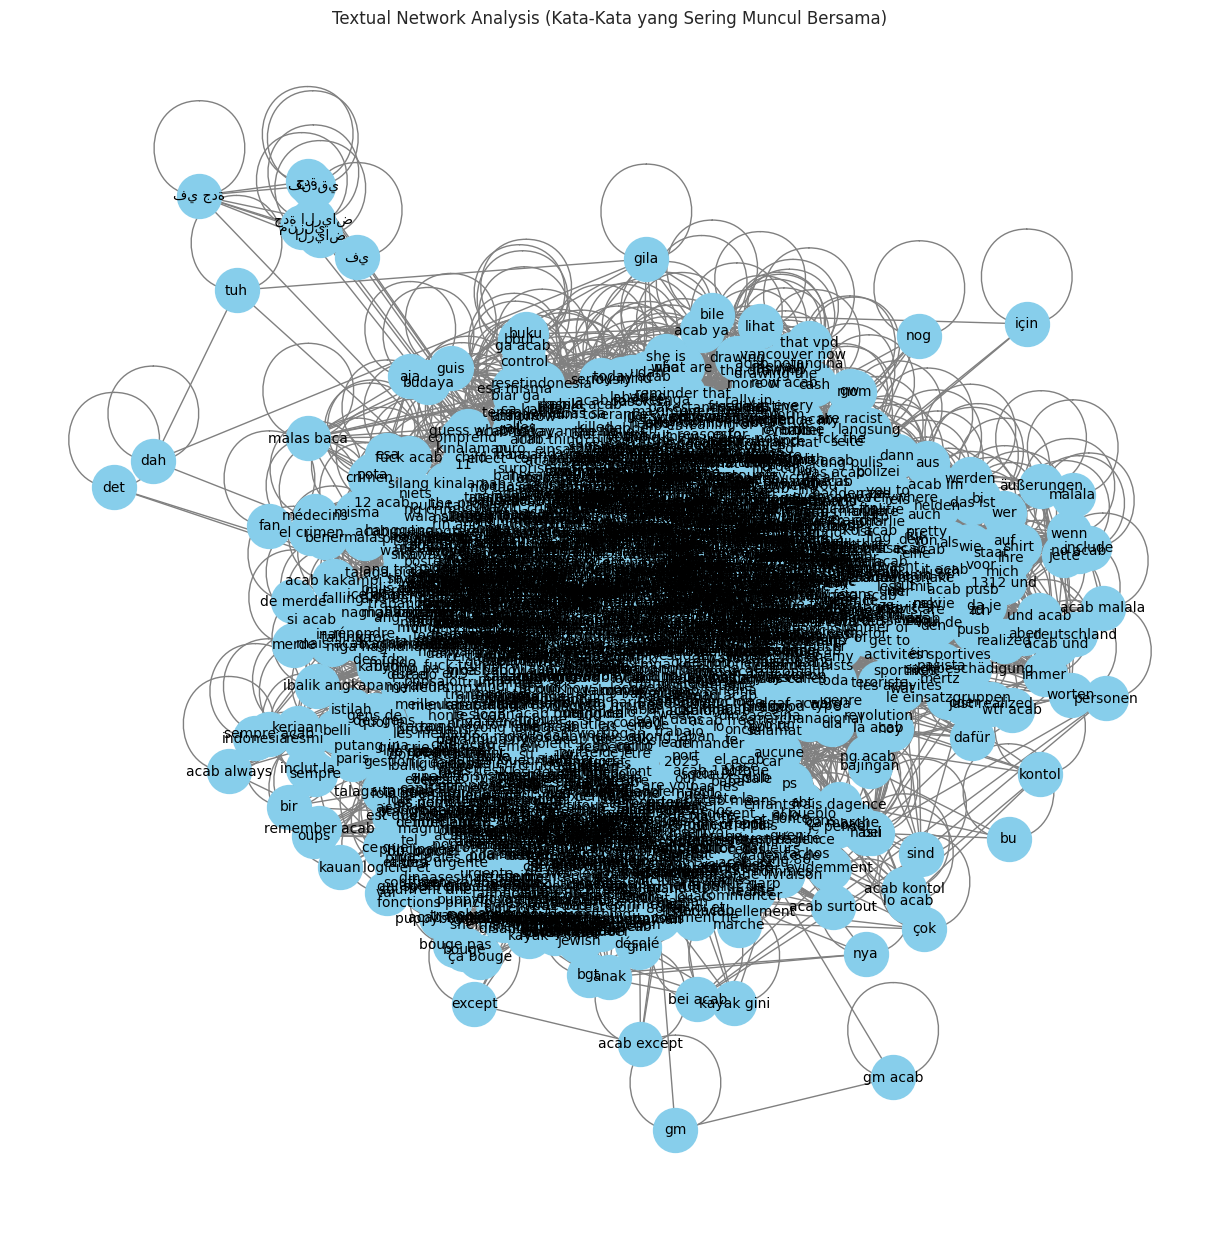

In [ ]:
# Install required packages if necessary
!pip install --upgrade networkx scipy nltk scikit-learn

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# Download stopwords Bahasa Indonesia
try:
    nltk.data.find('corpora/stopwords/indonesian')
except LookupError:
    nltk.download('stopwords')

# 1. Pastikan dataframe dan kolomnya tersedia
if 'df_sorted' in locals() and 'cleaned_text' in df_sorted.columns and not df_sorted['cleaned_text'].dropna().empty:
    texts = df_sorted['cleaned_text'].dropna().astype(str).tolist()

    # 2. Ambil stopwords Bahasa Indonesia
    indonesian_stop_words = stopwords.words('indonesian')

    # 3. Buat vectorizer n-gram 1 dan 2, min_df=2 supaya hanya yang sering muncul
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=indonesian_stop_words, min_df=2)
    X = vectorizer.fit_transform(texts)
    features = vectorizer.get_feature_names_out()

    if X.shape[0] > 0 and X.shape[1] > 0:
        # 4. Matriks co-occurrence
        co_occurrence_matrix = (X.T @ X)
        co_occurrence_matrix.setdiag(0)

        # 5. Buat graph (GANTI ke from_scipy_sparse_array)
        G = nx.from_scipy_sparse_array(co_occurrence_matrix)
        labels = {i: word for i, word in enumerate(features)}
        G = nx.relabel_nodes(G, labels)

        if G.number_of_nodes() > 0:
            plt.figure(figsize=(12, 12))
            pos = nx.spring_layout(G, k=0.3, seed=42)
            nx.draw(
                G, pos,
                with_labels=True,
                node_color='skyblue',
                edge_color='gray',
                node_size=1000,
                font_size=10
            )
            plt.title("Textual Network Analysis (Kata-Kata yang Sering Muncul Bersama)")
            plt.show()
        else:
            print("Graph kosong.")
    else:
        print("Tidak ada kata yang cukup sering muncul untuk divisualisasikan.")
else:
    print("Dataframe 'df_sorted' tidak ditemukan atau kolom 'cleaned_text' kosong.")
